In [1]:
from SimPEG import *
from simpegEM1D import EM1D, EM1DSurveyTD, Utils1D, get_vertical_discretization_time, set_mesh_1d
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from simpegEM1D import skytem_HM_2015, skytem_LM_2015
wave = skytem_HM_2015()
# LM
tind = 3
# time_input_currents = wave.current_times[-13:]
# input_currents = wave.currents[-13:]
time_input_currents = wave.current_times[-7:]
input_currents = wave.currents[-7:]
time = wave.time_gate_center[:tind]
hz = get_vertical_discretization_time(time, facter_tmax=0.5, factor_tmin=10.)

mesh1D = set_mesh_1d(hz)
depth = -mesh1D.gridN[:-1]
LocSigZ = -mesh1D.gridCC



TDsurvey = EM1DSurveyTD(
    rx_location = np.array([0., 0., 100.+30.]),
    src_location = np.array([0., 0., 100.+30.]),
    topo = np.r_[0., 0., 100.],
    depth = depth,
    rx_type = 'dBzdt',
    wave_type = 'general',
    src_type = 'CircularLoop',
    a = 13.,
    I = 1.,
    time = time,
    time_input_currents=time_input_currents,
    input_currents=input_currents,
    n_pulse = 2,
    base_frequency = 250.,
    use_lowpass_filter=False,
    high_cut_frequency=1e5
)

sig_half = 1e-3
sig_blk = 1e-2
chi_half = 0.
wires = Maps.Wires(('sigma', mesh1D.nC),('h', 1))
expmap = Maps.ExpMap(mesh1D)
sigmaMap = expmap * wires.sigma

sig  = np.ones(TDsurvey.n_layer)*sig_half
blk_ind = (-30>LocSigZ) & (-50<LocSigZ)
sig[blk_ind] = sig_blk
m_true = np.r_[np.log(sig), TDsurvey.h]

prob = EM1D(mesh1D, sigmaMap=sigmaMap, hMap=wires.h)
if prob.ispaired:
    prob.unpair()
if TDsurvey.ispaired:
    TDsurvey.unpair()
prob.pair(TDsurvey)
prob.chi = np.zeros(TDsurvey.n_layer)
d_true = TDsurvey.dpred(m_true)

In [3]:
wave = skytem_HM_2015()
# LM
tind = 3
# time_input_currents = wave.current_times[-13:]
# input_currents = wave.currents[-13:]
time_input_currents = wave.current_times[-7:]
input_currents = wave.currents[-7:]
time = wave.time_gate_center[:tind]
hz = get_vertical_discretization_time(time, facter_tmax=0.5, factor_tmin=10.)

mesh1D = Mesh.TensorMesh([1])


TDsurvey = EM1DSurveyTD(
    rx_location = np.array([0., 0., 100.+30.]),
    src_location = np.array([0., 0., 100.+30.]),
    topo = np.r_[0., 0., 100.],
    depth = depth,
    rx_type = 'dBzdt',
    wave_type = 'general',
    src_type = 'CircularLoop',
    a = 13.,
    I = 1.,
    time = time,
    time_input_currents=time_input_currents,
    input_currents=input_currents,
    n_pulse = 2,
    base_frequency = 250.,
    use_lowpass_filter=False,
    high_cut_frequency=1e5,
    half_switch=True
)

wires = Maps.Wires(('sigma', mesh1D.nC),('h', 1))
expmap = Maps.ExpMap(mesh1D)
sigmaMap = expmap * wires.sigma

prob = EM1D(mesh1D, sigmaMap=sigmaMap, hMap=wires.h)
if prob.ispaired:
    prob.unpair()
if TDsurvey.ispaired:
    TDsurvey.unpair()
prob.pair(TDsurvey)
prob.chi = np.zeros(TDsurvey.n_layer)
m0 = np.r_[np.log(sig_half), 20]
d_0 = TDsurvey.dpred(m0)

In [4]:
prob.getJ_sigma(m0)

array([[-1.75937059e-05],
       [-1.27989616e-05],
       [-9.46031014e-06]])

In [5]:
e = np.ones(3)

In [6]:
e.reshape([1,-1]).shape

(1, 3)

In [7]:
np.random.seed(1)
TDsurvey.dtrue = d_true
std = 0.02
noise = std*abs(TDsurvey.dtrue)*np.random.randn(*TDsurvey.dtrue.shape)
floor = 0.
std = 0.02
TDsurvey.dobs = TDsurvey.dtrue+noise
uncert = abs(TDsurvey.dobs)*std+floor

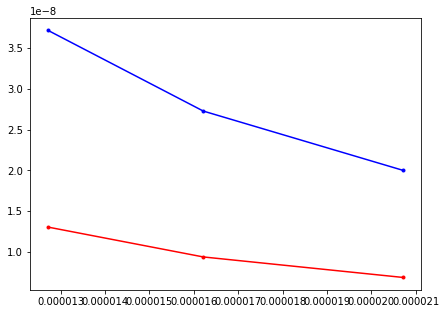

In [8]:
fig, axes = subplots(1,1, figsize = (7,5))
axes.plot(TDsurvey.time, -d_true, 'b.-')
axes.plot(TDsurvey.time, -d_0, 'r.-')
axes.set_xscale('linear');
axes.set_yscale('linear');

In [9]:
dmisfit = DataMisfit.l2_DataMisfit(TDsurvey)
dmisfit.W = 1./(abs(TDsurvey.dobs)*std+floor)

SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||


In [10]:
reg_sigma = Regularization.Simple(
    mesh1D, mapping=wires.sigma
)
mesh_h = Mesh.TensorMesh([1])
reg_h = Regularization.Simple(
    mesh_h, mapping=wires.h, 
)
reg = reg_sigma + reg_h
opt = Optimization.ProjectedGNCG(maxIter = 20)
opt.maxIterLS = 5
invProb = InvProblem.BaseInvProblem(dmisfit, reg, opt)
beta = Directives.BetaSchedule(coolingFactor=1., coolingRate=2)
target = Directives.TargetMisfit()
update_sense = Directives.UpdateSensitivityWeights()
invProb.beta=0.
inv = Inversion.BaseInversion(invProb, directiveList=[beta, target])
# inv = Inversion.BaseInversion(invProb, directiveList=[beta, betaest, target])
# inv = Inversion.BaseInversion(invProb, directiveList=[IRLS,betaest])

prob.counter = opt.counter = Utils.Counter()
opt.LSshorten = 0.5
opt.remember('xc')
mopt = inv.run(m0)

SimPEG.InvProblem will set Regularization.mref to m0.
SimPEG.InvProblem will set Regularization.mref to m0.

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  0.00e+00  1.60e+03  0.00e+00  1.60e+03    2.32e+03      0              
   1  0.00e+00  6.22e+01  2.37e-01  6.22e+01    1.09e+03      1              
   2  0.00e+00  2.07e+00  3.20e-01  2.07e+00    8.96e+01      0   Skip BFGS  
   3  0.00e+00  1.76e+00  3.14e-01  1.76e+00    4.64e-01      0              
------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = 1.5978e+02
0 : |xc-x_last| = 9.0452e+00 <= tolX*(1+|x0|) = 2.215

In [11]:
print (wires.h*m0)
print (wires.h*mopt)
print (TDsurvey.h)

[20.]
[29.03579728]
30.0


In [12]:
opt.counter.summary()
xc = opt.recall('xc')

Counters:
  ProjectedGNCG.activeSet                 :        4
  ProjectedGNCG.doEndIteration            :        4
  ProjectedGNCG.doStartIteration          :        4
  ProjectedGNCG.projection                :       20
  ProjectedGNCG.scaleSearchDirection      :        4

Times:                                        mean      sum
  EM1D.Jtvec_approx                       : 1.48e-03, 7.41e-03,    5x
  EM1D.Jvec_approx                        : 9.30e-04, 4.65e-03,    5x
  ProjectedGNCG.findSearchDirection       : 2.00e-02, 7.99e-02,    4x
  ProjectedGNCG.minimize                  : 8.08e-01, 8.08e-01,    1x
  ProjectedGNCG.modifySearchDirection     : 8.50e-02, 3.40e-01,    4x


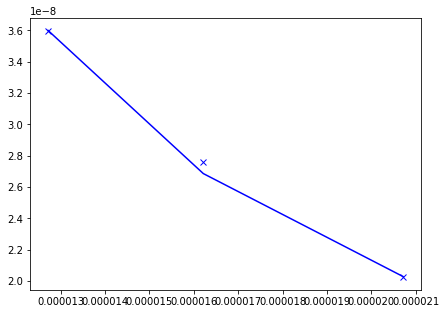

In [13]:
fig, axes = subplots(1,1, figsize = (7,5))
axes.plot(TDsurvey.time, -invProb.dpred, 'b-')
axes.plot(TDsurvey.time, -TDsurvey.dobs, 'bx')
axes.set_xscale('linear');
axes.set_yscale('linear');